In [1]:
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import GradScaler, autocast

Train input shape: (250000, 75)
Train label shape: (250000, 75)
Validation Input shape: (50000, 75)
Validation Label shape: (50000, 75)


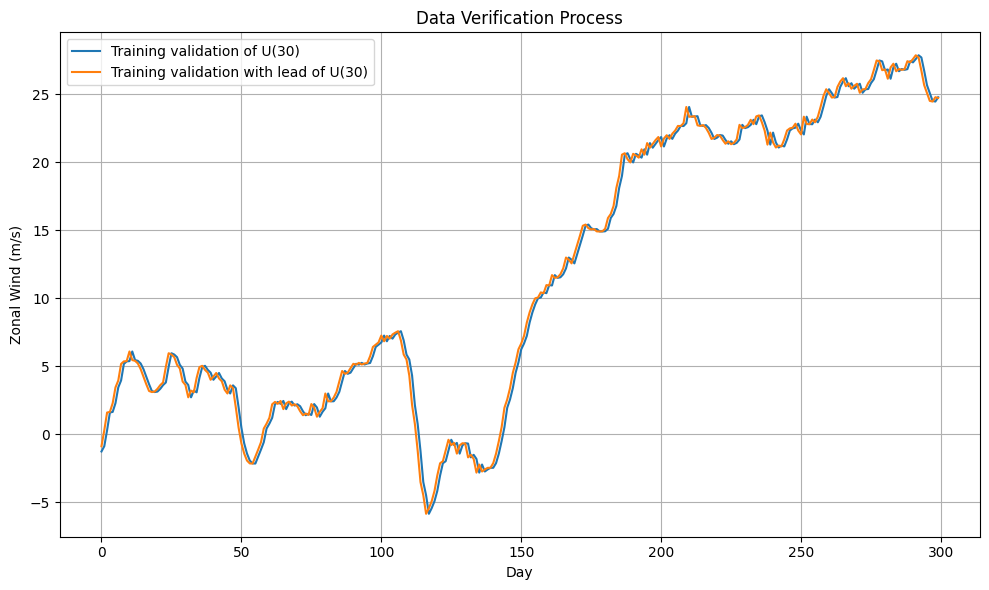

In [2]:
data = np.load("/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
data = data[:,1,:]

data_mean = np.mean(data, axis = 0)
data_std = np.std(data, axis = 0)
data = (data - data_mean) / data_std

trainN = 250_000
valN = 50_000
lead = 1
index = 63

np.random.seed(42)
shuffled_indices = np.random.permutation(trainN - lead + 1)

train_input = data[shuffled_indices, :]
train_label = data[shuffled_indices + lead, :]

val_input = data[trainN:trainN + valN, :]
val_label = data[trainN + lead:trainN + valN + lead, :]

print("Train input shape:", train_input.shape)
print("Train label shape:", train_label.shape)
print("Validation Input shape:", val_input.shape)
print("Validation Label shape:", val_label.shape)

train_input_tensor = torch.tensor(train_input)
train_label_tensor = torch.tensor(train_label)

val_input_tensor = torch.tensor(val_input)
val_label_tensor = torch.tensor(val_label)

plt.figure(figsize=(10,6))
plt.plot(val_input[:300, 63] * data_std[63] + data_mean[63], label = "Training validation of U(30)")
plt.plot(val_label[:300, 63] * data_std[63] + data_mean[63], label = "Training validation with lead of U(30)")
plt.title("Data Verification Process")
plt.xlabel("Day")
plt.ylabel("Zonal Wind (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
class Decoder(nn.Module):
    def __init__(self, input_dim, num_neurons):

        super(Decoder, self).__init__()

        self.fc_input = nn.Linear(input_dim, num_neurons)

        self.fc1 = nn.Linear(num_neurons, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, num_neurons)
        self.fc4 = nn.Linear(num_neurons, num_neurons)
        self.fc5 = nn.Linear(num_neurons, num_neurons)
        self.fc6 = nn.Linear(num_neurons, num_neurons)

        self.fc_output = nn.Linear(num_neurons, 75)

    def forward(self, x):

        x = torch.relu(self.fc_input(x))

        x = torch.relu(self.fc1(x)) + x
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        x = torch.relu(self.fc5(x)) + x
        x = torch.relu(self.fc6(x)) + x

        output = torch.relu(self.fc_output(x))
        return output

class NeuralNet(nn.Module):
    def __init__(self, input_dim, num_neurons):
        super(NeuralNet, self).__init__()
        self.decoder = Decoder(input_dim, num_neurons)

    def forward(self, x):
        output = self.decoder(x)
        return output

# Hyperparameters

In [4]:
input_dim = 75
num_neurons = 1024
batch_size = 1024
epochs = 100

# Training

In [5]:
training_losses = []
validation_losses = []
z_dims = [0, 1, 2, 4, 8, 16, 32]

In [9]:
for z_dim in z_dims:
    
    model = NeuralNet(input_dim + z_dim, num_neurons).cuda()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    z = torch.zeros(batch_size, z_dim).float().cuda()
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
        model.train()
        for batch in range(0, trainN - batch_size, batch_size):

            input_batch = train_input_tensor[batch:batch+batch_size, :].float().cuda()
            label_batch = train_label_tensor[batch:batch+batch_size, :].float().cuda()
            z = torch.randn_like(z).float().cuda()

            optimizer.zero_grad()
            
            with autocast(device_type="cuda"):

                input_batch_z = torch.cat((input_batch, z), dim = 1)
                output = model(input_batch_z)

                loss = F.mse_loss(output, label_batch)

                loss.backward()
                optimizer.step()

        print("Training loss: ", loss.item())
        training_losses.append(loss.item())

        model.eval()
        for batch in range(0, valN - batch_size, batch_size):

            input_batch = val_input_tensor[batch:batch + batch_size].float().cuda()
            label_batch = val_label_tensor[batch:batch + batch_size].float().cuda()
            z = torch.randn_like(z).float().cuda()

            with torch.no_grad():
                with autocast(device_type="cuda"):

                    input_batch_z = torch.cat((input_batch, z), dim = 1)
                    output = model(input_batch_z)

                    val_loss = F.mse_loss(input_batch, label_batch)

        print("Validation Loss: ", val_loss.item())
        print()
        validation_losses.append(loss.item())
        
    model_save_path = f"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/nn_models/save_{z_dim}"
    torch.save(model.state_dict(), model_save_path)

Epoch: 1
Training loss:  0.7351365089416504
Validation Loss:  0.039854008704423904

Epoch: 2
Training loss:  0.7334023714065552
Validation Loss:  0.039854008704423904

Epoch: 3
Training loss:  0.7328581213951111
Validation Loss:  0.039854008704423904

Epoch: 4
Training loss:  0.7325209379196167
Validation Loss:  0.039854008704423904

Epoch: 5
Training loss:  0.7255179286003113
Validation Loss:  0.039854008704423904

Epoch: 6
Training loss:  0.7253417372703552
Validation Loss:  0.039854008704423904

Epoch: 7
Training loss:  0.725210428237915
Validation Loss:  0.039854008704423904

Epoch: 8
Training loss:  0.7251428961753845
Validation Loss:  0.039854008704423904

Epoch: 9
Training loss:  0.7251126766204834
Validation Loss:  0.039854008704423904

Epoch: 10
Training loss:  0.718539297580719
Validation Loss:  0.039854008704423904

Epoch: 11
Training loss:  0.7183651924133301
Validation Loss:  0.039854008704423904

Epoch: 12
Training loss:  0.7182816863059998
Validation Loss:  0.03985400870

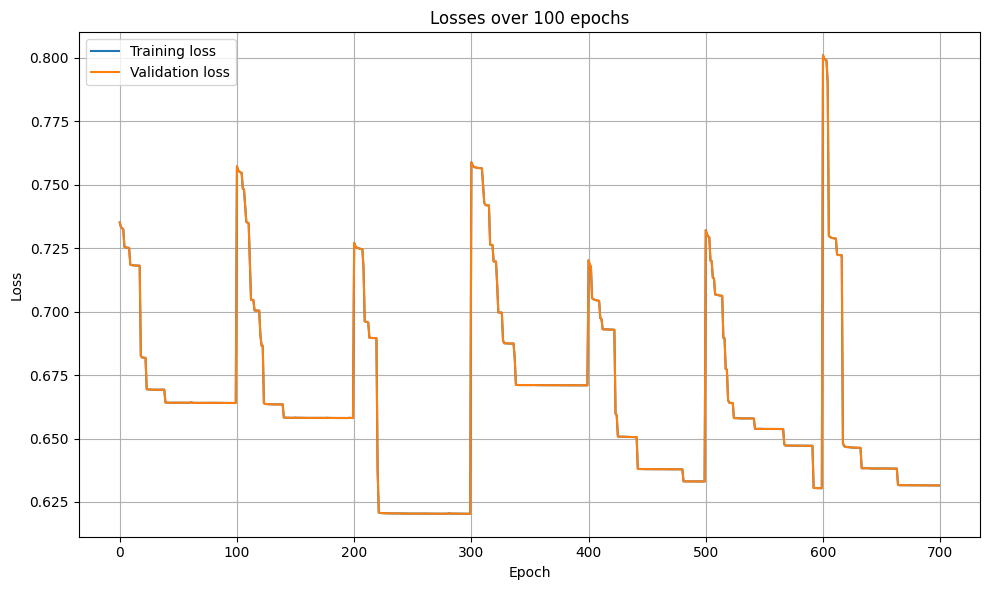

In [10]:
plt.figure(figsize=(10,6))
plt.plot(training_losses, label = f"Training loss")
plt.plot(validation_losses, label = f"Validation loss")
plt.title(f"Losses over {epochs} epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Inference

In [11]:
timesteps = 30000

In [ ]:
data = data * data_std + data_mean

75 0
Loading model from /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/nn_models/save_0
torch.Size([1, 0])


/tmp/ipykernel_40391/1418576598.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


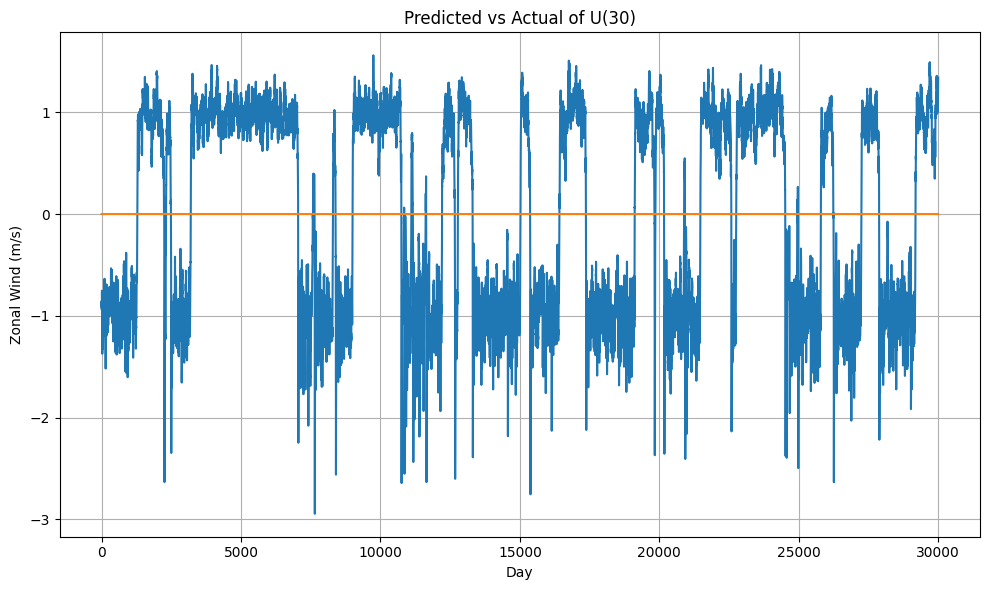

75 1
Loading model from /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/nn_models/save_1
torch.Size([1, 1])


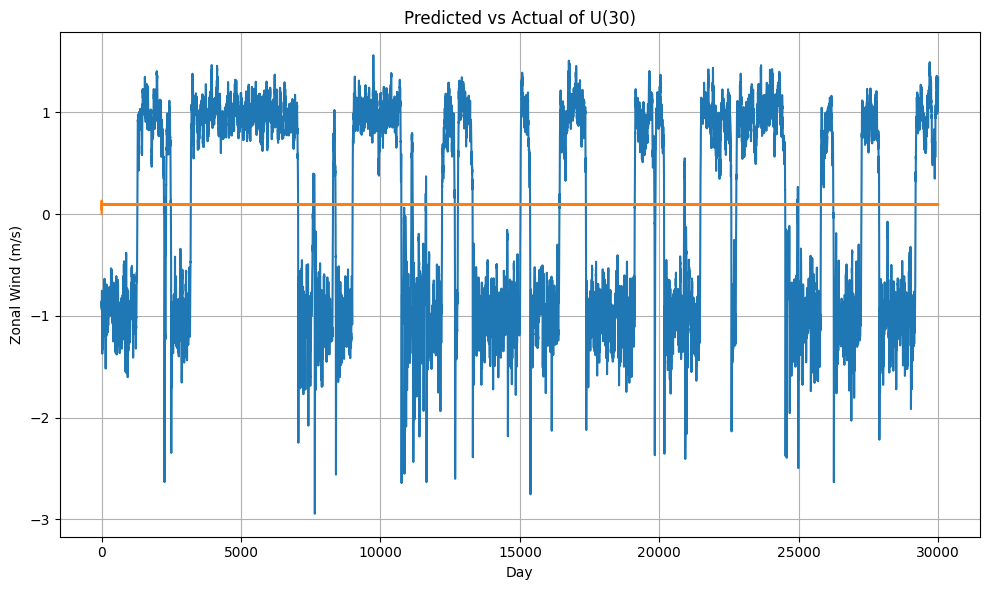

75 2
Loading model from /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/nn_models/save_2
torch.Size([1, 2])


KeyboardInterrupt: 

In [ ]:
for i, z_dim in enumerate(z_dims):

    if z_dim > 0:
        z = torch.zeros((batch_size, z_dim))
    print(input_dim, z_dim)
    model = NeuralNet(input_dim + z_dim, num_neurons).cuda()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    model_path = f"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/nn_models/save_{z_dim}"

    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))

    ic = torch.reshape(torch.tensor(data[0, :]),(1,75)).float().cuda(non_blocking=True)
    save = np.zeros([timesteps, 75])
    z = torch.zeros(1, z_dim).float().cuda()

    for step in range(timesteps):

        if not step:

            z = torch.randn_like(z).float().cuda()
            print(z.shape)
            if z_dim > 0:
                ic_z = torch.cat((ic, z), dim = 1)
            else:
                ic_z = ic
            output = model(ic_z)
            save[step, :] = output.detach().cpu().numpy()
        
        if step:

            z = torch.randn_like(z).float().cuda()
            ic = torch.tensor(save[step-1, :], device="cuda").unsqueeze(0).float().cuda()
            if z_dim > 0:
                ic_z = torch.cat((ic, z), dim = 1)
            else:
                ic_z = ic
            output = model(ic_z)
            save[step, :] = output.detach().cpu().numpy()

    save = save * data_std + data_mean
    plt.figure(figsize=(10,6))
    plt.plot(data[:30000, 63], label = "Actual U(30)")
    plt.plot(save[:, 63], label = "Predicted U(30)")
    plt.title("Predicted vs Actual of U(30)")
    plt.xlabel("Day")
    plt.ylabel("Zonal Wind (m/s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()